In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import njit
from scipy.stats import truncnorm

In [52]:
# This version of the model doesn´t use the classical activity-assigmen, but rather draws values from [0,1] from
# a certain distribution and saves them to an array. After that, the array is normalized and is used to pick a certain
# number of nodes, so that different distributions don´t change the global activity in the network.
# for \gamma=2.1 <#a> is approximately 102

#################### ASSIGN_ACT_PROBABILITY #########################

def Assign_Act_Probability(N, model, model_params):
    probs = np.zeros(N)
    # Fill array and normalize
    if model == 0:
        norm = 0
        # Powerlaw distribution with exponent model_params[0]
        for i in range(N):
            probs[i] = 1-np.random.power(model_params[0]+1)
            norm += probs[i]
        # Normalize
        for i in range (N):
            probs[i] = probs[i] / norm

    if model == 1:
        norm = 0
        mean = model_params[0]
        std = model_params[1]

        a = (0 - mean) / std
        b = (1 - mean) / std

        # Gaussian mean=model_params[0], std=model_params[1]
        for i in range(N):
            probs[i] = truncnorm.rvs(a, b, mean, std, 1)
            norm += probs[i]
        # Normalize
        for i in range (N):
            probs[i] = probs[i] / norm

    return probs


#################### PROBABILITY_DISTRIBUTION_OPINION ###############

@njit
def Probability_Distribution_Opinion(G, numb_node, T, beta, Phi):
    # Calculates probability of node numb_node connecting to each other node.
    N = len(G)
    prob = np.zeros(N)

    # Calculate Norm
    norm = 0
    for i in range (N):
        #sp = 0
        distance = 0
        if i != numb_node: 
            # numb_node is the number of the selected node
            for u in range (T):
                for v in range (T):
                    distance += (G[i][u] - G[numb_node][u]) * (G[i][v] - G[numb_node][v]) * Phi[u][v]
            norm += np.sqrt(distance)**(-beta)
        

    # Calculate Probability of contact
    for i in range (N): 
        if i != numb_node:
            #sp = 0
            distance = 0
            for u in range (T):
                for v in range (T):
                    distance += (G[i][u] - G[numb_node][u]) * (G[i][v] - G[numb_node][v]) * Phi[u][v]
            prob[i] = (np.sqrt(distance)**(-beta) / norm)
    return prob
    
#################### ODEs ###########################################

@njit
def ODEs(N, T, A, K, alpha, Phi, current_opinions, opinions_step):
    # Determine social influence to return the differential. current_opinions and opinions_step
    # are arrays of the form [..., [agent_i_op1, agent_i_op2], [agent_i+1_op1, agent_i+1_op2], ...]
    influence = np.zeros((N,T))
    for i in range (N):
        for o in range (T):
            # Go through connected agents of i
            count = 0
            while A[i][count] != N+1:
                influence[i][o] += np.tanh(alpha * np.dot(Phi, current_opinions[A[i][count]])[o])
                count += 1

    #return differential
    dxdt = -opinions_step + K * influence
    return dxdt

#################### RK4 #############################################

@njit
def RK4(G, T, A, K, alpha, Phi, dt):
    N = len(G)
    # Save current opinions
    current_opinions = np.zeros((N,T))
    for i in range (N):
        for j in range (T):
            current_opinions[i][j] += G[i][j]

    # Calculate ks
    k1 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions)
    k2 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions + 0.5 * k1)
    k3 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions + 0.5 * k2)
    k4 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions + k3)

    # Calculate total change and update opinions
    k = 1/6 * (k1 + 2*k2 + 2*k3 + k4)
    current_opinions += k
    for i in range (N):
        for j in range (T):
            G[i][j] = current_opinions[i][j]

#################### UPDATE_ADJACENCY_MATRIX #########################

@njit
def Update_Adjacency_Matrix(Adj, A, N):
    # Updates Adjacency Matrix. If a connection is established multiple times in the
    # Network iterations, the connection is still only counted as one connection,
    # so that it isn´t weighted.
    for i in range (N):
        j = 0
        # Again N+1 is the breaking value
        while A[i][j] != N+1:
            con = A[i][j]
            Adj[i][con] = 1
            Adj[con][i] = 1
            j += 1

##################### CONNECT #######################################

def Connect(N, m, G, G_num, T, beta, Phi, probs, num_act):
    # Form adjacency array for timestep. Array entry i contains all adjacent nodes of i. Other values are initialized with N+1
    # as a breaking value so ODEs doesn´t go through the whole array
    A = np.full((N,N), N+1)
    # Create counting array to place adjacent nodes correctly in array
    count_arr = np.zeros(N, dtype=int)

    act_count = 0

    # Pick active nodes
    picks_act = np.random.choice(G_num, num_act, replace=False, p=probs)

    for i in picks_act:
        act_count += 1
        # Pick m other nodes randomly. No exception of i needed, since
        # P_D_O excludes i already
        prob = Probability_Distribution_Opinion(G, i, T, beta, Phi)
        picks = np.random.choice(G_num, m, replace=False, p=prob)
        #Update adjacency list: append nodes j to i´s place and vice versa
        for j in picks:
            A[i][count_arr[i]] = j
            A[j][count_arr[j]] = i
            count_arr[i] += 1
            count_arr[j] += 1

    return A, act_count

##################### SAVE ###########################################

def Save(save, Adj, N, T, filename):
    # Export save to csv
    # Create column indices (optional)
    nodes_ind = []
    for i in range (N):
        nodes_ind.append(f'Node_{i}')
    # Create row indices (optional)
    op_ind = []
    op_ind.append('activity')
    for i in range (runtime_net):
        for j in range (T):
            op_ind.append(f'iteration {i} op {j}')
    # Create Dataframe and convert it to .csv
    df = pd.DataFrame(save, columns = nodes_ind, index = op_ind)
    df.to_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Distributions\{filename}.csv", index = False, header = False)

    # Save Adjacency Matrix
    pd.DataFrame(Adj).to_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Distributions\{filename}_mat.csv", index = False, header = False)
    




##################### OPINION_DYNAMICS ################################

def Opinion_Dynamics(N, T, m, K, alpha, beta, gamma, Phi, eps1, eps2, runtime_net, runtime_op, dt, filename, model, model_params, num_act):
    # Parameters N to eps1 are the same as in the paper introducing the model. Eps2 is the upper bound for activity,
    # runtime_net is the number of times a new AD-network is formed, runtime_op is the number of opinion-iterations
    # performed on that network. Default is runtime_op = 1. dt is the integration time-step and filename is a string
    # containing the name of the file in which the opinion dynamcis of the agents are saved (filename.csv).

    # Create array to save opinions of all agents after every network-iteration
    save = np.zeros((runtime_net * T + 1, N))
    # Create Array that contains node's activities and opinions
    G = np.zeros((N,T))
    # Give each array entry (node) a number, save in array G_num
    G_num = np.arange(0,N)
    # To later retrieve the integrated network over the last 70 iterations (As in the paper) create
    # an adjacency matrix
    Adj = np.zeros((N,N))
    # save # of active nodes per iteration
    acts = np.zeros(runtime_net)

    # Create Activity-Probability Array 
    probs_act = Assign_Act_Probability(N, model, model_params)
    plt.figure()
    plt.hist(probs_act, density=True, bins=100)
    plt.show()

    # Save Activity-Probabilites in first array of save
    save[0] = probs_act

    # Initialize Activity and Opinions of Nodes
    for i in range (N):
        for j in range (T):
            G[i][j] = np.random.normal(0, np.sqrt(2.5))

    # Perform Iterations until runtime_net is reached
    iteration_net = 0
    while iteration_net < runtime_net:

        # Form connections between Agents
        A, acts[iteration_net] = Connect(N, m, G, G_num, T, beta, Phi, probs_act, num_act)
        
        # Calculate the influence of the nodes on eachother
        iteration_op = 0
        while iteration_op < runtime_op:
            # Update opinions via Runge-Kutta 4
            RK4(G, T, A, K, alpha, Phi, dt)
            # increase iteration
            iteration_op += 1
        
        # Save opinions of agents
        for i in range (N):
            for j in range(T):
                # first row of save contains activities. After that for each iteration there´s a row for each iteration,
                # i.e. for two opinions two rows per iteration. 
                save[(T*iteration_net)+j+1][i] += G[i][j]
        
        # Update adjacency matrix if last 70 iterations are reached
        if iteration_net >= runtime_net - 71:
            Update_Adjacency_Matrix(Adj, A, N)

        # Print progress bar
        if iteration_net % (int(runtime_net/100)) == 0:
            percent = int(100 * iteration_net/runtime_net)
            #print(percent)
            left = 40 * percent // 100
            right = 40 - left
    
            tags = "#" * left
            spaces = " " * right
            percents = f"{percent:.0f}%"
    
            print("\r[", tags, spaces, "]", percents, sep="", end="", flush=True)

        iteration_net += 1

    Save(save, Adj, N, T, filename)

    act_med = 0
    for i in range (len(acts)):
        act_med += acts[i]
    act_med = act_med/runtime_net

    return act_med
        
            



In [62]:
N = 2500 # 1000 nodes should be the minimum, below initial fluctuations take over and polarization becomes instable
T = 2
m = int(np.floor((N+50)/100)) # np.floor(N+50/100)
K = 3
alpha = 3.0
beta = 3.0
gamma = 2.1
Phi = np.array([[1.0,0.0],[0.0,1.0]])
eps1 = 0.01
eps2 = 1.0
runtime_net = 10**3 # Stability is reached from about 500 iterations
runtime_op = 1
step = 0.01
print("m: ", m)
print("Phi: ", Phi[0][0], Phi[0][1], Phi[1][0], Phi[1][1])
# File Names should be a 2-dim array with the first dimension being for each wanted value of a parameter
# and the second dimension full of array names for the multiple simulations.
model = 1
model_params = [0.5, 0.5]
File_Names = [f"Gaussian_m{model_params[0]}_std{model_params[1]}"]

m:  25
Phi:  1.0 0.0 0.0 1.0


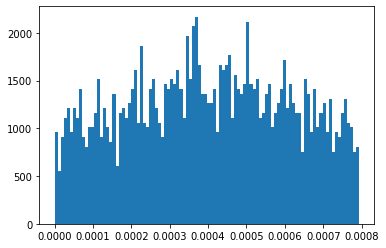

[####################################### ]99%

102.0

In [63]:
Opinion_Dynamics(N, T, m, K, alpha, beta, gamma, Phi, eps1, eps2, runtime_net, runtime_op, step, File_Names[0], model, model_params, 102)

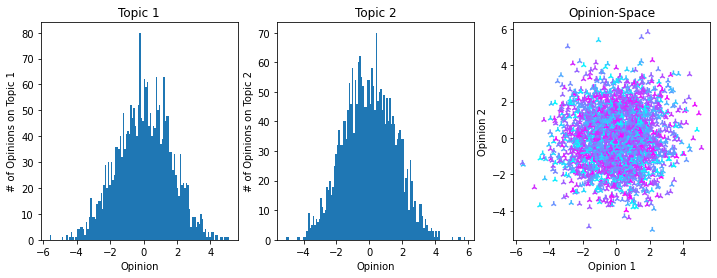

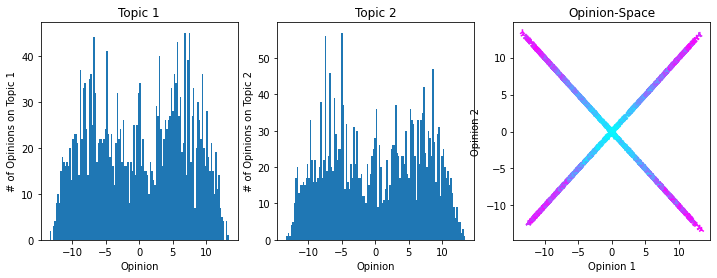

In [64]:
data = np.loadtxt(f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Distributions\{File_Names[0]}.csv', delimiter=',')

def Plot_Opinion_Distribution_2d(data1, data2, data_act):
    op1_list = data1
    op2_list = data2

    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].set_title("Topic 1")
    ax[0].set_xlabel("Opinion")
    ax[0].set_ylabel("# of Opinions on Topic 1")
    ax[0].hist(op1_list, bins=120)
    ax[1].set_title("Topic 2")
    ax[1].set_xlabel("Opinion")
    ax[1].set_ylabel("# of Opinions on Topic 2")
    ax[1].hist(op2_list, bins=120)
    ax[2].set_title("Opinion-Space")
    ax[2].set_xlabel("Opinion 1")
    ax[2].set_ylabel("Opinion 2")
    ax[2].scatter(op1_list, op2_list, c=data_act, cmap='cool', marker = '2')
    plt.show()

Plot_Opinion_Distribution_2d(data[1], data[2], data[0])
Plot_Opinion_Distribution_2d(data[len(data)-2], data[len(data)-1], data[0])